#Import nessessary libraries

In [5]:
import numpy as np
import pandas as pd
import cv2
#import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from tensorflow.keras.preprocessing import image
import tensorflow as tf

from keras import backend as K

from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
plt.gray()

import random

import glob

from sklearn.model_selection import train_test_split

<Figure size 432x288 with 0 Axes>

In [6]:
def plot_loss(history):
  plt.plot(history.history['loss'], '-s')
  plt.plot(history.history['val_loss'], '--o')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper left')
  plt.show()

#Denoising MNIST Fashion

##Load MNIST dataset

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [8]:
# Number of pixels in one image (28x28 = 748) 
N_pixels = X_train.shape[1]*X_train.shape[2]

# Convert to floats and normalize to [0, 1]
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print("X_train.shape = ", X_train.shape, "\nX_test.shape = ", X_test.shape)

X_train.shape =  (60000, 28, 28) 
X_test.shape =  (10000, 28, 28)


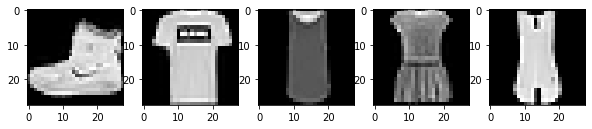

In [9]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(10, 8)
for i in range(5):
    ax[i].imshow(X_train[i, :, :])

##Add noise to the data

Refer to this [link](https://imgaug.readthedocs.io/en/latest/source/overview/arithmetic.html) for different kinds of nosie.

In [10]:
#Salt and Pepper
noise = iaa.SaltAndPepper(0.1)
noise_generator = iaa.Sequential([noise])

X_train_noisy = noise_generator.augment_images(X_train * 255) / 255
X_test_noisy = noise_generator.augment_images(X_test * 255) / 255

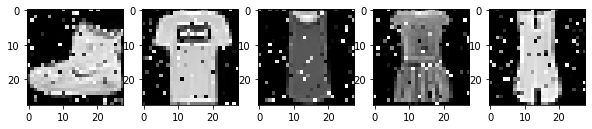

In [11]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(10, 8)
for i in range(5):
    ax[i].imshow(X_train_noisy[i, :, :])

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_noisy, X_train, 
                                                  test_size = 0.2, random_state = 0)

print("X_train shape =", X_train.shape)
print("X_val shape = ", X_val.shape)

X_train shape = (48000, 28, 28)
X_val shape =  (12000, 28, 28)


##Define an autoencoder

In [58]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder

x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu')(x1)
x1 = UpSampling2D((2, 2))(x1)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x1)


In [59]:
model = Model(input_img, decoded)

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [61]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 16)          4624

##Train the AE

In [45]:
X_train_noisy.shape

(60000, 28, 28)

In [46]:
X_train.shape

(48000, 28, 28)

In [48]:
X_train = X_train.reshape(-1, 28,28,1)

In [51]:
y_train = y_train.reshape(-1,28,28,1)

In [52]:
X_val = X_val.reshape(-1, 28,28,1)

In [53]:
y_val = y_val.reshape(-1, 28,28,1)

In [62]:
history=model.fit(X_train, y_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, y_val))

Epoch 1/10
375/375 [==============================] - 21s 26ms/step - loss: 0.3338 - val_loss: 0.2990
Epoch 2/10
375/375 [==============================] - 10s 27ms/step - loss: 0.2934 - val_loss: 0.2889
Epoch 3/10
375/375 [==============================] - 9s 24ms/step - loss: 0.2873 - val_loss: 0.2850
Epoch 4/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2838 - val_loss: 0.2820
Epoch 5/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2814 - val_loss: 0.2800
Epoch 6/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2794 - val_loss: 0.2794
Epoch 7/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2779 - val_loss: 0.2767
Epoch 8/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2767 - val_loss: 0.2758
Epoch 9/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2756 - val_loss: 0.2754
Epoch 10/10
375/375 [==============================] - 8s 22ms/step - loss: 0.2749 - val_

##Plot the losses

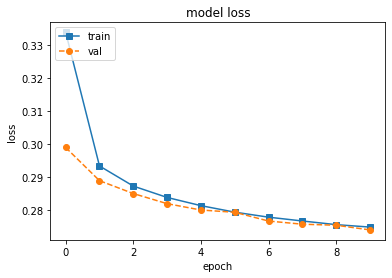

In [63]:
plot_loss(history)

##Test the denoising ability of the AE
- Read some noisy images in the test set
- Pass noisy images through the AE

- Print out the original images + corresponding noisy images
- Print out the images returned by the AE

Generate $10$ indices (wothout duplicates). 

In [64]:
num_of_test_images = 10
indices_test_images = random.sample(range(len(X_test)), num_of_test_images)
print("type of indices_test_images: {}\nindices_test_images = {}".format(type(indices_test_images), indices_test_images ))

type of indices_test_images: <class 'list'>
indices_test_images = [401, 2786, 5773, 9094, 8728, 5956, 9603, 9069, 4993, 1642]


Extract those images from the test set

In [67]:
test_images = X_test_noisy[indices_test_images, :, :]
print(test_images.shape)

(10, 28, 28)


Pass them through the AE

In [68]:
test_images_AE = model.predict(test_images)

In [69]:
print("Size of the output: ", test_images_AE.shape)

Size of the output:  (10, 28, 28, 1)


Let's squeeze it

In [73]:
test_images_AE_squeezed = tf.squeeze(test_images_AE)

In [74]:
print("Size of the squeezed output: ", test_images_AE_squeezed.shape)

Size of the squeezed output:  (10, 28, 28)


Let's see the result!

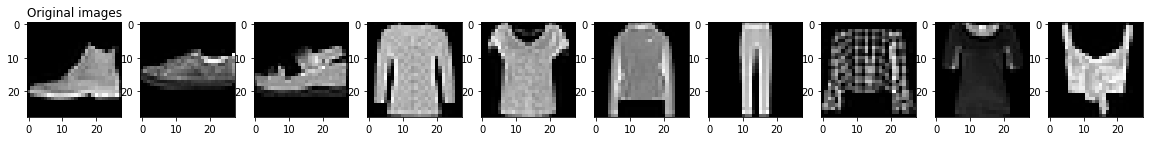

In [77]:
f, ax = plt.subplots(1, len(test_images))
f.set_size_inches(20, 10)
for i, a in enumerate(indices_test_images):
    ax[i].imshow(X_test[a , :, :])

ax[0].set_title('Original images')
plt.show()

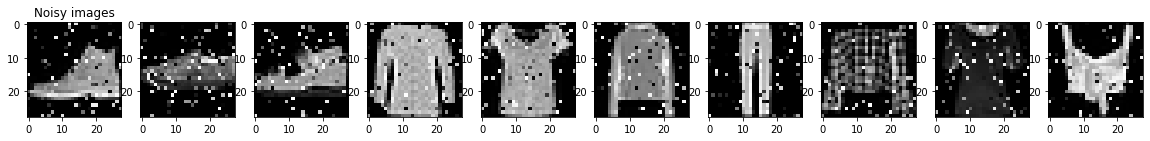

In [78]:
f, ax = plt.subplots(1, len(indices_test_images))
f.set_size_inches(20, 10)
for i, a in enumerate(indices_test_images):
    ax[i].imshow(X_test_noisy[a , :, :])
    
ax[0].set_title('Noisy images')
plt.show()

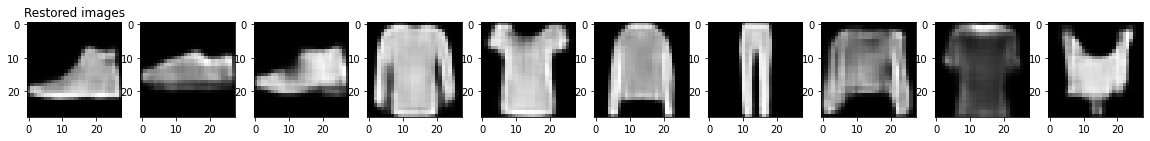

In [79]:
f, ax = plt.subplots(1, len(indices_test_images))
f.set_size_inches(20, 10)
for i in range(num_of_test_images):
    ax[i].imshow(test_images_AE_squeezed[i , :, :])
    
ax[0].set_title('Restored images')
plt.show()

#Denoising documents

##Load data

<font color="red"> Change this link! </font>

In [80]:
from google.colab import drive

In [81]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/................/Lab_Denoising_Autoencoder/'

The below cells allows us to get the paths to all files in one folder that satisfy the requirement (in this case we want to get paths to all .png files)

Note that we need to use `sorted()` here. <font color="red"> Try not to use it and think of why we need it! </font>

In [82]:
train_image_paths = sorted(glob.glob('/content/drive/MyDrive/Cher Eng Lim - noisy documents.zip (Unzipped Files)/noisy documents/train/*.png'))
train_image_clean_paths = sorted(glob.glob('/content/drive/MyDrive/Cher Eng Lim - noisy documents.zip (Unzipped Files)/noisy documents/train_cleaned/*.png'))
test_image_paths = sorted(glob.glob('/content/drive/MyDrive/Cher Eng Lim - noisy documents.zip (Unzipped Files)/noisy documents/test/*.png'))

In [83]:
print(train_image_paths[1]) 
print(train_image_clean_paths[1])

/content/drive/MyDrive/Cher Eng Lim - noisy documents.zip (Unzipped Files)/noisy documents/train/102.png
/content/drive/MyDrive/Cher Eng Lim - noisy documents.zip (Unzipped Files)/noisy documents/train_cleaned/102.png


Set the height and width of documents.

In [98]:
target_height = 420
target_width = 540

After obtaining all paths, we can read images, scale them and save them in a list.

In [99]:
def load_image(path):
  # First, create a list to store all images
  # This list has 4 dimensions:
  #   - len(path): number of images
  #   - target_height and target_width are slf-explanatory
  #   - 1: one channel (gray images)
  image_list = np.zeros((len(path), target_height, target_width, 1))

  # Now, have a for-loop to scan all paths in "path"
  # Read the image and normalize it
  for i, fig in enumerate(path):
    img = image.load_img(fig, grayscale=True, target_size = (target_height, target_width))
    x = image.img_to_array(img).astype('float32')
    x = x / 255.0
    image_list[i] = x

  return image_list

In [100]:
train_images = load_image(train_image_paths)
train_images_clean = load_image(train_image_clean_paths)
test_images = load_image(test_image_paths)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [101]:
print("train_images shape = ", train_images.shape)
print("train_images_clean shape = ", train_images_clean.shape)
print("test_images shape = ", test_images.shape)

train_images shape =  (144, 420, 540, 1)
train_images_clean shape =  (144, 420, 540, 1)
test_images shape =  (72, 420, 540, 1)


Split the `train_images` and `train_images_clean` into 

- `X_train`: taken from `train_images`
- `X_val`: taken from `train_images`
- `y_train`: taken from `train_images_clean`
- `y_val`: taken from `train_images_clean`

In [102]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_images_clean, test_size = 0.15, random_state = 0)
print("X_train shape =", X_train.shape)
print("X_val shape = ", X_val.shape)

X_train shape = (122, 420, 540, 1)
X_val shape =  (22, 420, 540, 1)


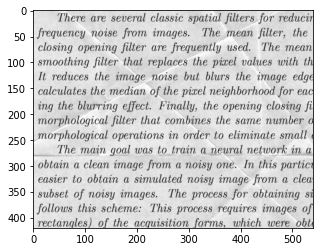

In [103]:
plt.imshow(X_train[0, :, :, 0], cmap = "gray")

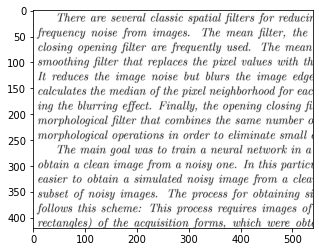

In [104]:
plt.imshow(y_train[0, :, :, 0], cmap = "gray")

##AE

In [151]:
input_img = Input(shape=(target_height, target_width, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder

x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x1 = UpSampling2D((2, 2))(x1)
#x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
#x1 = UpSampling2D((2, 2))(x1)
#x1 = Conv2D(64, (3, 3), activation='relu')(x1)
#x1 = UpSampling2D((2, 2))(x1)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x1)


In [152]:
model = Model(input_img, decoded)

In [153]:
model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.001))

In [154]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 420, 540, 32)      320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 210, 270, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 210, 270, 32)      9248      
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 420, 540, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 420, 540, 1)       289 

In [155]:
history=model.fit(X_train, y_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, y_val))

Epoch 1/30
4/4 [==============================] - 12s 2s/step - loss: 0.1820 - val_loss: 0.1455
Epoch 2/30
4/4 [==============================] - 2s 486ms/step - loss: 0.1269 - val_loss: 0.0955
Epoch 3/30
4/4 [==============================] - 2s 490ms/step - loss: 0.0837 - val_loss: 0.0684
Epoch 4/30
4/4 [==============================] - 2s 493ms/step - loss: 0.0677 - val_loss: 0.0674
Epoch 5/30
4/4 [==============================] - 2s 492ms/step - loss: 0.0695 - val_loss: 0.0701
Epoch 6/30
4/4 [==============================] - 2s 490ms/step - loss: 0.0712 - val_loss: 0.0700
Epoch 7/30
4/4 [==============================] - 2s 485ms/step - loss: 0.0703 - val_loss: 0.0678
Epoch 8/30
4/4 [==============================] - 2s 490ms/step - loss: 0.0675 - val_loss: 0.0644
Epoch 9/30
4/4 [==============================] - 2s 492ms/step - loss: 0.0642 - val_loss: 0.0624
Epoch 10/30
4/4 [==============================] - 2s 489ms/step - loss: 0.0629 - val_loss: 0.0619
Epoch 11/30
4/4 [====

##Traing the AE

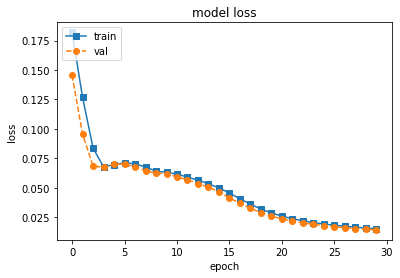

In [156]:
plot_loss(history)

##Test the AE

Pass `test_images` through the AE.

In [157]:
prediction = model.predict(test_images)

Choose one `index`. Multiply the corresponding prediction with $255$. Reshape it to `(258, 540)`.

Read the corresponding original image from `test_images`.

In [160]:
index = 5

image_out = prediction[index] * 255.0
image_out = image_out.reshape(target_height, target_width)

image_in = test_images[index] * 255.0
image_in = image_in.reshape(target_height, target_width)

In [161]:
prediction.shape

(72, 420, 540, 1)

In [144]:
image_out

array([[141.85759, 166.13539, 172.48946, ..., 168.49338, 163.05142,
        139.91228],
       [157.66203, 200.82353, 208.28604, ..., 205.09338, 195.49504,
        150.22676],
       [164.91754, 212.88063, 218.32072, ..., 213.53703, 205.9397 ,
        150.73067],
       ...,
       [164.61052, 211.1264 , 215.01147, ..., 203.25821, 196.87712,
        142.49258],
       [162.26564, 204.8974 , 207.21178, ..., 195.30359, 188.65787,
        140.37427],
       [147.55939, 174.26674, 173.98706, ..., 156.44067, 154.17699,
        125.15754]], dtype=float32)

In [128]:
image_in

array([[231.00000143, 229.00000155, 228.00000161, ..., 224.00000185,
        221.00000203, 222.00000197],
       [232.00000137, 234.00000125, 233.00000131, ..., 221.00000203,
        214.00000244, 215.00000238],
       [226.00000173, 228.00000161, 226.00000173, ..., 217.00000226,
        218.00000221, 218.00000221],
       ...,
       [224.00000185, 224.00000185, 227.00000167, ..., 201.00000322,
        200.00000328, 216.00000232],
       [224.00000185, 226.00000173, 228.00000161, ..., 223.00000191,
        221.00000203, 214.00000244],
       [230.00000149, 229.00000155, 228.00000161, ..., 227.00000167,
        222.00000197, 221.00000203]])

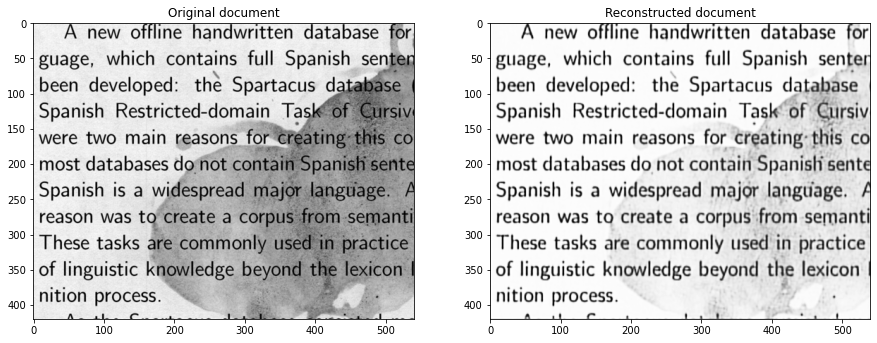

In [162]:
f = plt.figure(figsize = (15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(image_in, cmap = 'gray')
ax1.set_title("Original document")

ax2.imshow(image_out, cmap = 'gray')
ax2.set_title("Reconstructed document")

plt.show()

Let's test the AE with a noisy image which is not similar to those in the dataset.

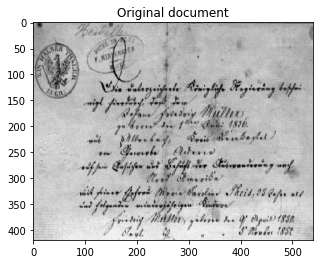

In [166]:
img = image.load_img('/content/Cher Eng Lim - test_2.GIF', color_mode = "grayscale", target_size = (target_height, target_width))

# Read and scale it
x  = image.img_to_array(img).astype('float32')
x = x / 255.0

f = plt.figure(figsize = (8, 4))
plt.imshow(x[:, :, 0], cmap = 'gray')
plt.title("Original document")
plt.show()

Reshape `x` to `(-1, target_height, target_width, 540, 1)`. Pass it through the AE. Print out the result.

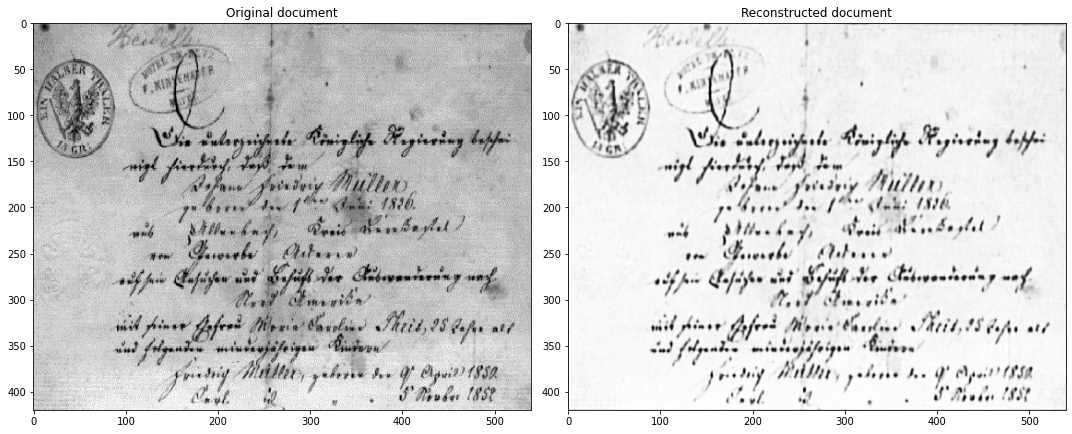

In [167]:
x = x.reshape(-1, target_height, target_width, 1)
x_pred = model.predict(x)

f = plt.figure(figsize = (15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(x[0, :, :, 0], cmap = 'gray')
ax1.set_title("Original document")

ax2.imshow(x_pred[0, :, :, 0], cmap = 'gray')
ax2.set_title("Reconstructed document")

plt.tight_layout()
plt.show()

##test_1.gif##

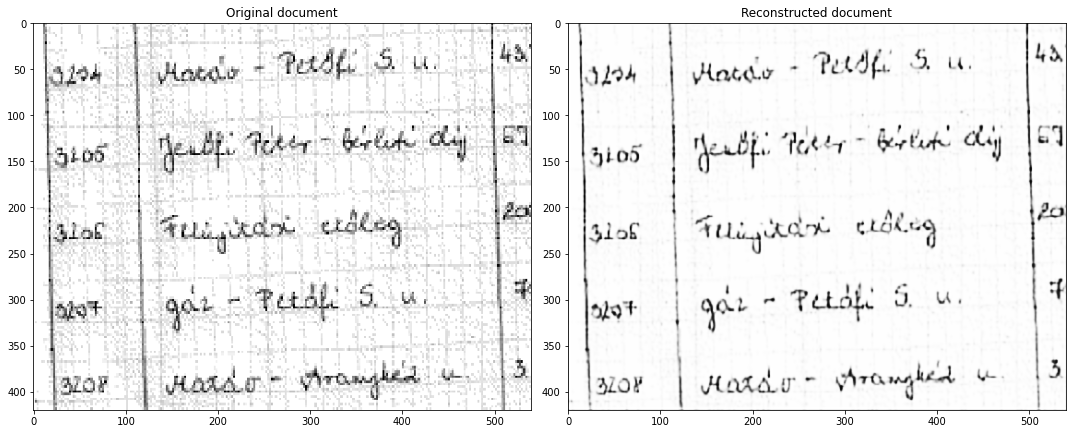

##test_2.gif##

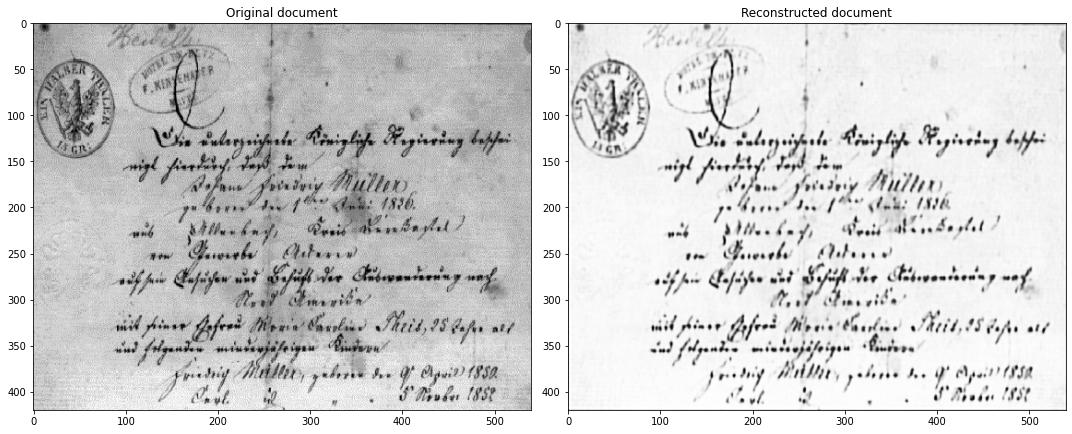